In [42]:
# -*- coding: utf-8 -*-
import logging
import os
from pathlib import Path
import click
from dotenv import find_dotenv, load_dotenv

from datasets import load_dataset, DatasetDict, Image, Dataset, concatenate_datasets
import wandb
import yaml
from transformers.trainer_callback import EarlyStoppingCallback
from artifact_classification.utils import ConfigLoader
from torchvision.transforms import (
    Compose,
    Normalize,
    ToTensor,
    CenterCrop,
    Resize,
)
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    AutoTokenizer,
)
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import gc
import torch
import numpy as np

In [3]:
config = "bm5-white_date"

args = ConfigLoader(config, "../configs/train_bm_configs.yaml", "../configs/train_bm_default.yaml")
if args.problem_type == "image":
    fts = ["image", args.label_col]
elif args.problem_type == "text":
    fts = [args.text_column, args.label_col]
ds_lim = (
    load_dataset(args.dataset)["train"]
    .select_columns(fts)
    .to_pandas()
    .dropna(subset=[args.label_col], inplace=False)
)

num_counts = ds_lim[args.label_col].value_counts()
ds_lim = ds_lim[ds_lim[args.label_col].isin(num_counts[num_counts > args.lower_lim].index)]

train, val_test = train_test_split(
    ds_lim,
    stratify=ds_lim[args.label_col],
    test_size=2 * args.testset_size,
    random_state=42,
)
val, test = train_test_split(
    val_test, stratify=val_test[args.label_col], test_size=0.5, random_state=42
)
del ds_lim, val_test, num_counts
gc.collect()

# Chunking is necessary as the dataset is too large to fit into memory
chunk_size = 10000
train_chunk_data = []
for i in range(0, len(train), chunk_size):
    train_chunk = train[i : i + chunk_size]
    train_chunk_dataset = Dataset.from_pandas(train_chunk)
    train_chunk_data.append(train_chunk_dataset)

# Concatenate the chunks into a single Dataset
train = concatenate_datasets(train_chunk_data)
val = Dataset.from_pandas(val)
test = Dataset.from_pandas(test)
dataset = DatasetDict(
    {
        "train": train,
        "validation": val,
        "test": test,
    }
)
dataset = dataset.rename_column(args.label_col, "label")

Updating with:
{'config': 'bm5-white_date', 'dataset': 'james-burton/BritishMuseum-white', 'wandb_proj_name': 'British Museum', 'model_base': 'google/efficientnet-b3', 'problem_type': 'image', 'lower_lim': 5, 'label_col': 'production_date_middle'}


{'config': 'bm5-white_date', 'fast_dev_run': False, 'do_train': True, 'do_predict': True, 'batch_size': 128, 'output_root': 'models/', 'num_epochs': 100, 'early_stopping_patience': 5, 'grad_accumulation_steps': 1, 'seed': 42, 'logging_steps': 10, 'lr_scheduler': 'linear', 'warmup_ratio': 0, 'weight_decay': 0, 'device': 'cuda', 'num_workers': 1, 'resume_from_checkpoint': False, 'predict_batch_size': 16, 'save_total_limit': 1, 'lr': 5e-05, 'pytorch2_0': True, 'max_length': 512, 'text_column': 'Description', 'fp16': True, 'testset_size': 0.13, 'dataset': 'james-burton/BritishMuseum-white', 'wandb_proj_name': 'British Museum', 'model_base': 'google/efficientnet-b3', 'problem_type': 'image', 'lower_lim': 5, 'label_col': 'production_date_middle'}

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

In [8]:
torch.log(torch.tensor(dataset["train"]["label"]))

tensor([5.4293,    nan,    nan,  ...,    nan, 5.6664,    nan])

In [43]:
normal_data = np.array(torch.tensor(dataset["train"]["label"])).reshape(-1, 1)

In [44]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(normal_data)

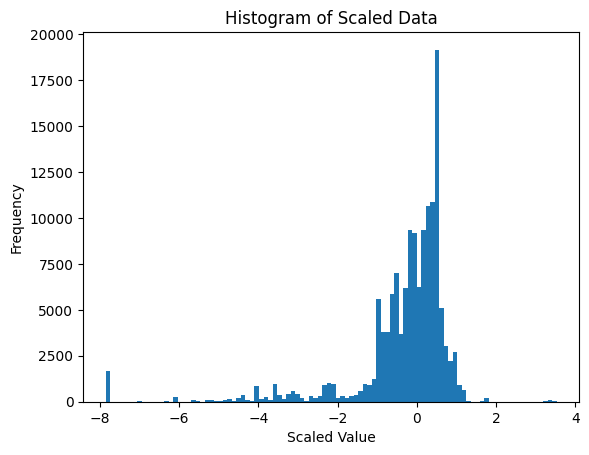

In [45]:
import matplotlib.pyplot as plt

plt.hist(scaled_data, bins=100)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

In [46]:
scaled_data.shape

(142208, 1)

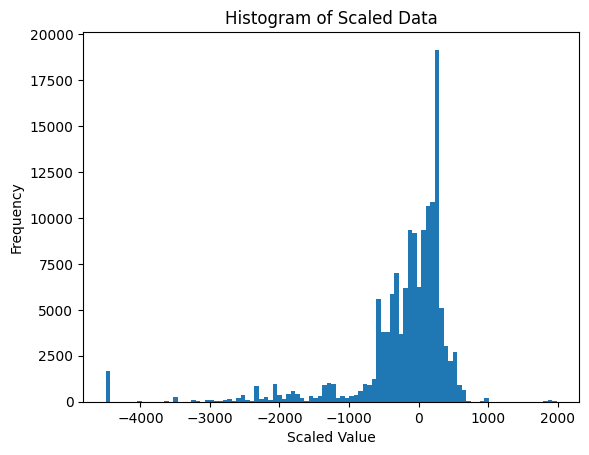

In [47]:
plt.hist(normal_data, bins=100)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

In [30]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from scipy.ndimage import convolve1d
import numpy as np


def get_lds_kernel_window(lds_kernel="gaussian", lds_ks=9, lds_sigma=1):
    r"""Function to determine the label distribution smoothing kernel window

    lds_kernel (str): LDS kernel type
    lds_ks (int): LDS kernel size (should be an odd number).
    lds_sigma (float): LDS gaussian/laplace kernel sigma
    """

    assert lds_kernel in ["gaussian", "triang", "laplace"]
    half_ks = (lds_ks - 1) // 2

    if lds_kernel == "gaussian":
        base_kernel = [0.0] * half_ks + [1.0] + [0.0] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=lds_sigma) / max(
            gaussian_filter1d(base_kernel, sigma=lds_sigma)
        )
    elif lds_kernel == "triang":
        kernel_window = triang(lds_ks)
    else:

        def laplace(x):
            return np.exp(-abs(x) / lds_sigma) / (2.0 * lds_sigma)

        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(
            map(laplace, np.arange(-half_ks, half_ks + 1))
        )

    return kernel_window


def prepare_LDS_weights(
    labels,
    n_bins=None,
    label_range=None,
    reweight="inv",
    lds_kernel="gaussian",
    lds_ks=9,
    lds_sigma=1,
    max_rel_weight=None,
    show_plot=True,
):

    assert reweight in {"inv", "sqrt_inv"}
    labels_shape = labels.shape
    if n_bins is None:
        labels = labels.astype(int)
        n_bins = np.max(labels) - np.min(labels)
    num_per_label, bin_edges = np.histogram(labels, bins=n_bins, range=label_range)
    new_labels = np.searchsorted(bin_edges, labels, side="left")
    new_labels[new_labels == 0] = 1
    if reweight == "sqrt_inv":
        num_per_label = np.sqrt(num_per_label)
    lds_kernel_window = get_lds_kernel_window(
        lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma
    )
    smoothed_value = convolve1d(num_per_label, weights=lds_kernel_window, mode="constant")
    if show_plot:
        plt.figure(figsize=(20, 6))  # Set the figure size to 10 inches by 6 inches
        plt.bar(
            bin_edges[:-1],
            num_per_label / num_per_label.sum(),
            width=(bin_edges[1] - bin_edges[0]),
            color="lime",
            edgecolor="black",
            label="original",
        )
        plt.plot(
            bin_edges[:-1], smoothed_value / smoothed_value.sum(), color="red", label="smoothed"
        )
        plt.title(f"Label distribution by bin (reweight={reweight})")
        plt.legend(loc="best")
        plt.show()
    num_per_label = smoothed_value[new_labels.flatten() - 1].reshape(*labels_shape)
    weights = 1 / num_per_label
    weights[num_per_label == 0] = 0
    if max_rel_weight is not None:
        weights = np.clip(weights, None, np.min(weights) * max_rel_weight)
    weights = weights / weights.sum() * len(labels)
    return torch.Tensor(weights)

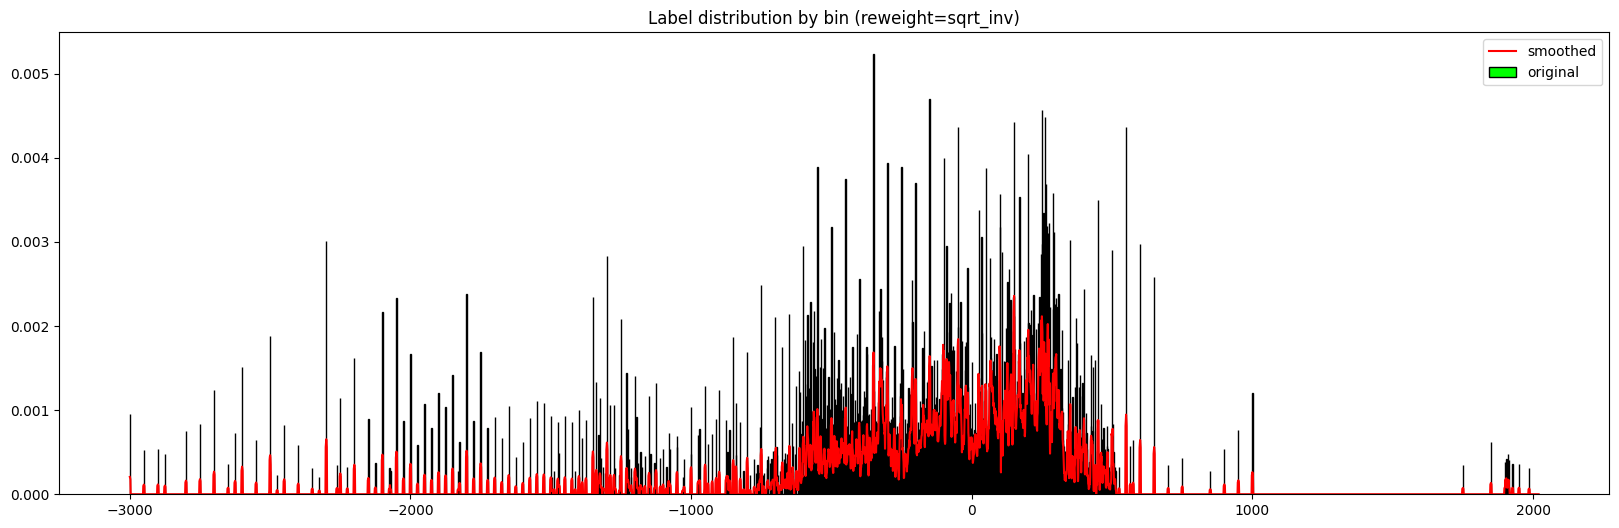

tensor([[0.6786],
        [1.0187],
        [4.2340],
        ...,
        [1.3606],
        [0.5498],
        [0.7079]])

In [52]:
prepare_LDS_weights(
    # scaled_data,
    normal_data,
    n_bins=5021,
    label_range=(-3000, 2021),
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
)

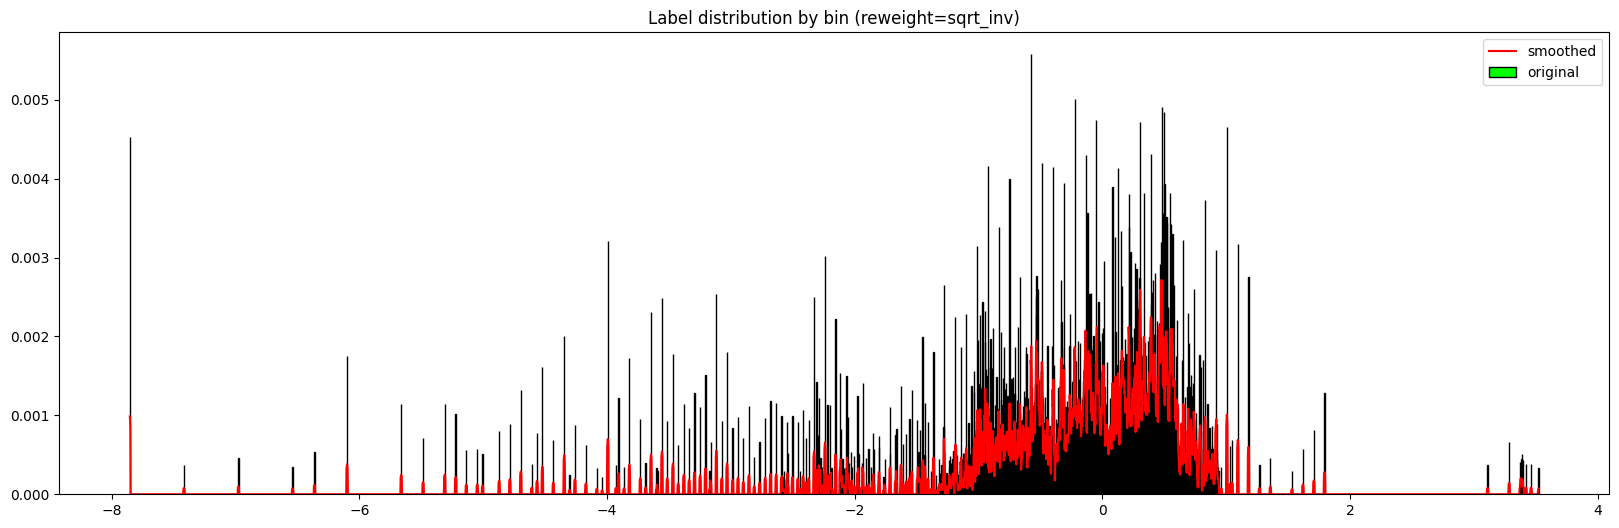

tensor([[0.7511],
        [0.9125],
        [4.6445],
        ...,
        [0.8185],
        [0.5370],
        [0.7946]])

In [54]:
prepare_LDS_weights(
    scaled_data,
    # normal_data,
    n_bins=5021,
    # label_range=(-3000, 2021),
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
)

In [97]:
sum_less_than_3000 = np.sum(normal_data < -3000)
sum_greater_than_500 = np.sum(normal_data > 500)

normal_data_3000_500 = normal_data[(normal_data > -3000) & (normal_data < 500)].reshape(-1, 1)


def transform_labels(data, scaler=None):
    r"""Function to transform the labels"""
    lower_bound = -3000
    upper_bound = 500
    data = np.clip(data, lower_bound, upper_bound)
    data = -data
    lower_bound = -upper_bound
    upper_bound = -lower_bound
    data = np.log(data - lower_bound + 1)

    if scaler == None:
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(data)
        return scaled_data, scaler
    else:
        scaled_data = scaler.transform(data)
        return scaled_data


scaled_data, scaler = transform_labels(normal_data)

In [98]:
scaled_data_3000_500 = scaler.fit_transform(normal_data_3000_500)

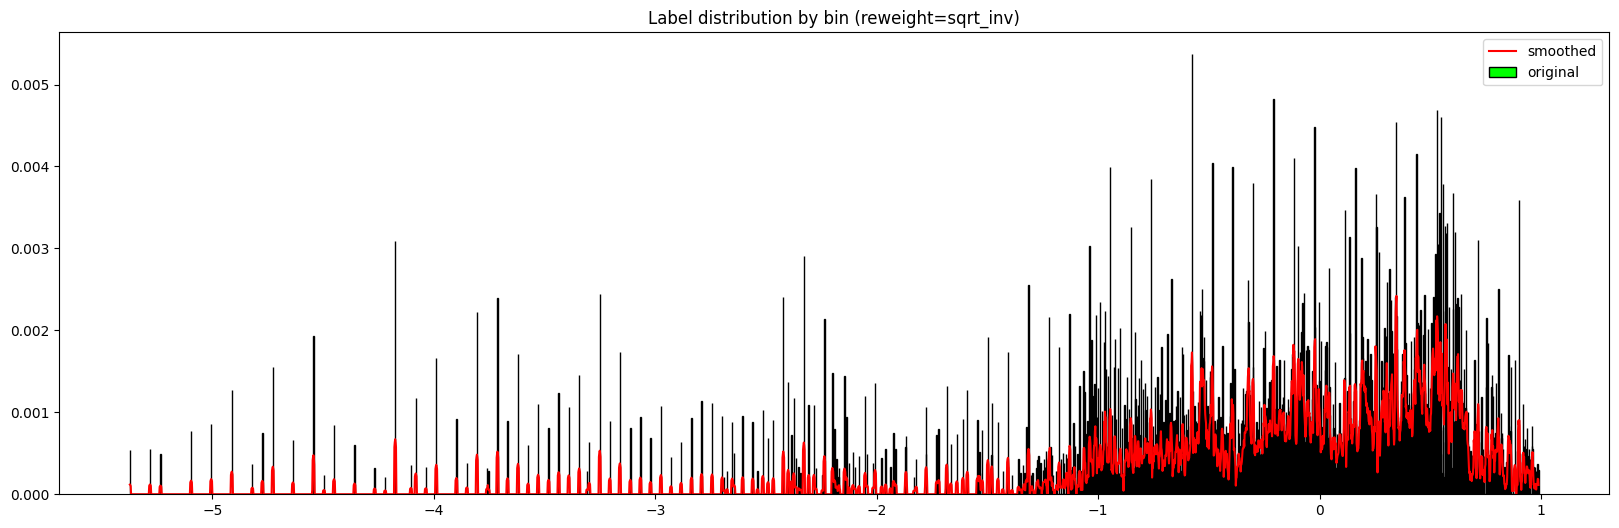

tensor([[0.9194],
        [3.0496],
        [4.3712],
        ...,
        [0.9326],
        [0.5665],
        [0.7626]])

In [99]:
prepare_LDS_weights(
    scaled_data_3000_500,
    # normal_data,
    n_bins=3500,
    # label_range=(-3000, 2021),
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
)

In [100]:
def move_and_log_scale(data, lower_bound, upper_bound):
    r"""Function to move and log scale the data

    data (np.array): input data
    lower_bound (float): lower bound of the data
    upper_bound (float): upper bound of the data
    """

    data = np.clip(data, lower_bound, upper_bound)
    data = np.log(data - lower_bound + 1)
    return data


move_and_log_scale(normal_data, -3000, 500)

array([[8.079927 ],
       [7.790696 ],
       [7.716906 ],
       ...,
       [7.862882 ],
       [8.098643 ],
       [7.9606724]], dtype=float32)

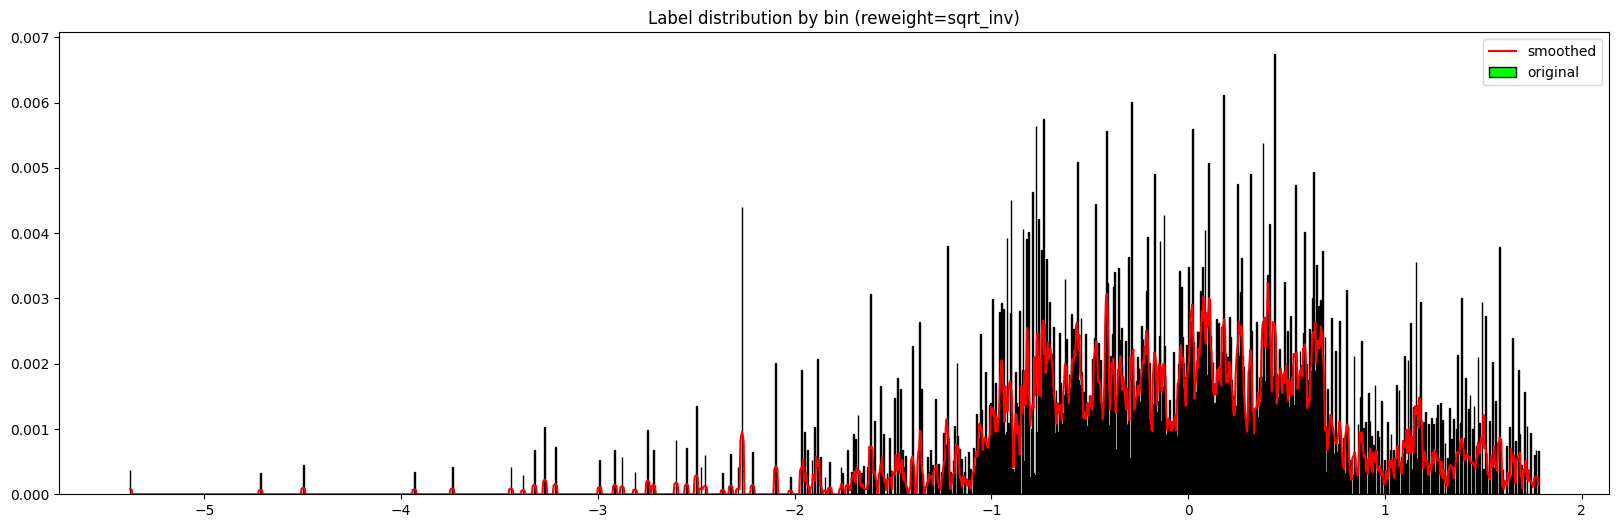

tensor([[0.9963],
        [0.5624],
        [1.2755],
        ...,
        [0.7193],
        [0.8355],
        [0.7722]])

In [101]:
prepare_LDS_weights(
    # move_and_log_scale(normal_data, -3000, 500),
    scaler.fit_transform(move_and_log_scale(-normal_data_3000_500, -500, 3000)),
    # normal_data,
    n_bins=1750,
    # label_range=(-3000, 2021),
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
)

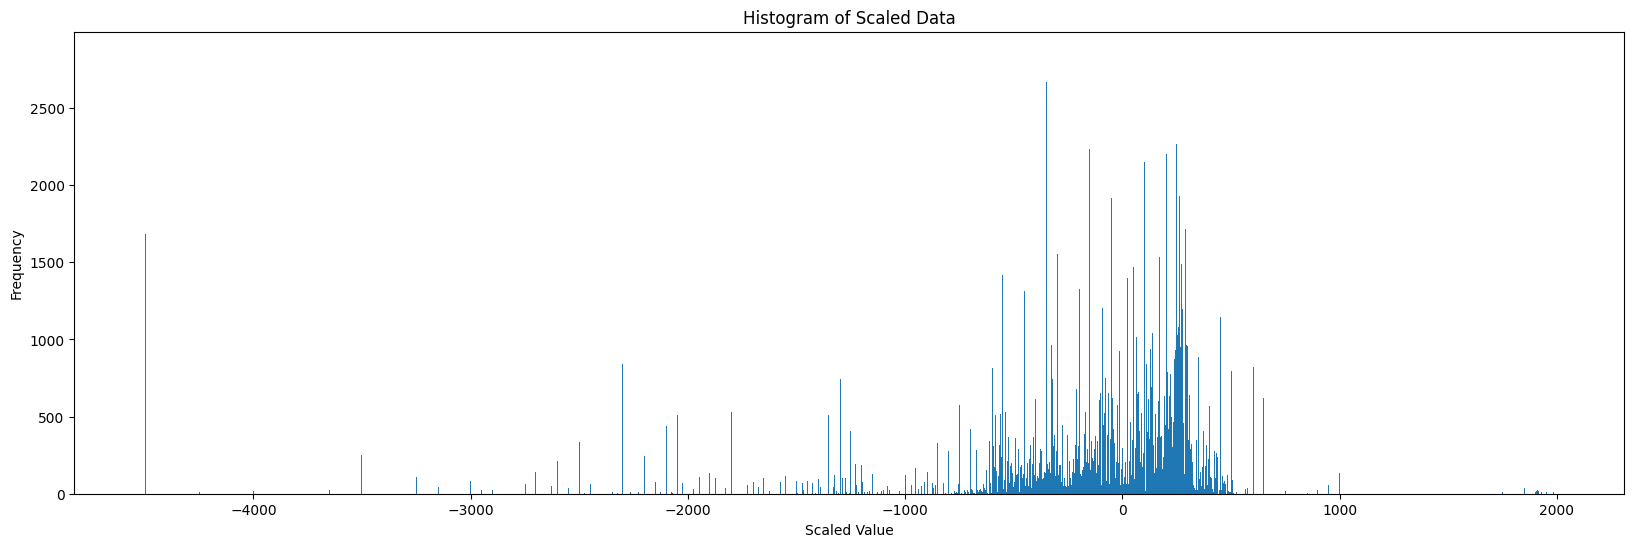

In [102]:
plt.figure(figsize=(20, 6))  # Set the figure size to 10 inches by 6 inches
plt.hist(normal_data, bins=1750)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

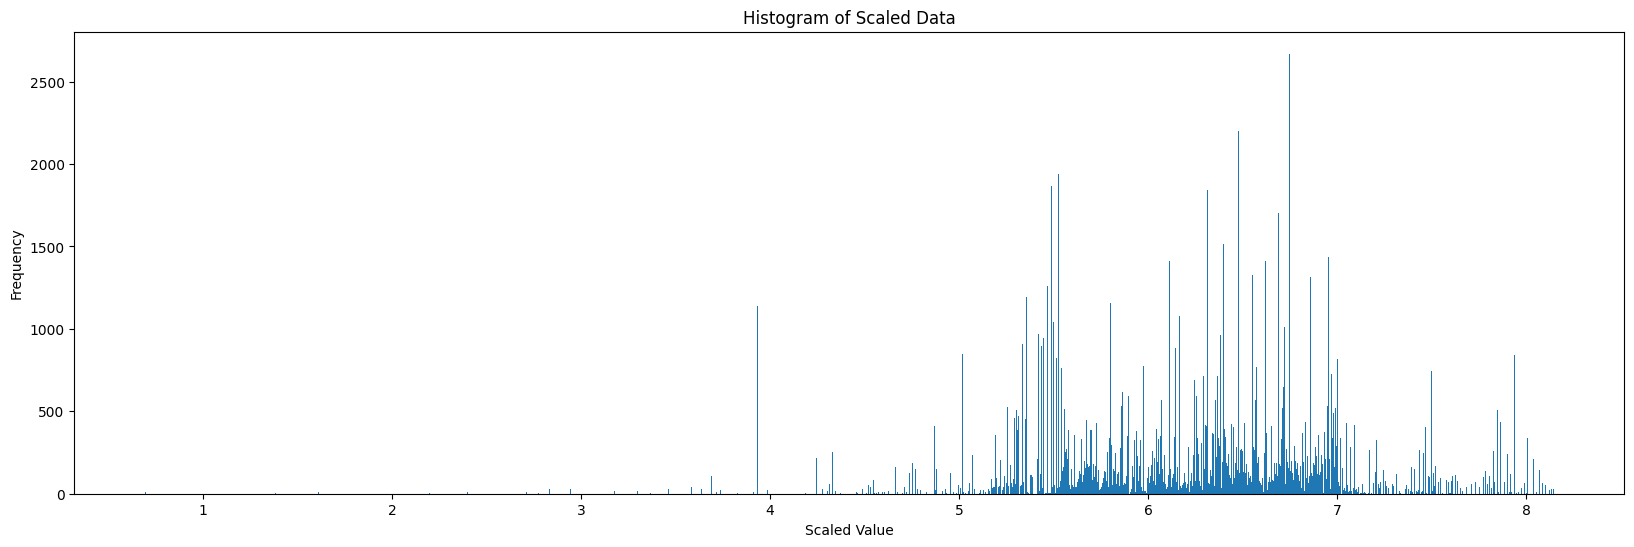

In [103]:
plt.figure(figsize=(20, 6))  # Set the figure size to 10 inches by 6 inches
plt.hist(move_and_log_scale(-normal_data_3000_500, -500, 3000), bins=1750)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

In [110]:
min(scaled_data_3000_500_2)

array([-5.3726935], dtype=float32)

In [111]:
scaled_data_3000_500 = scaler.fit_transform(move_and_log_scale(-normal_data_3000_500, -500, 3000))
scaled_data_3000_500_2 = scaler.fit_transform(normal_data_3000_500)

In [105]:
print(np.std(scaled_data_3000_500), np.mean(scaled_data_3000_500))
print(np.std(scaled_data_3000_500_2), np.mean(scaled_data_3000_500_2))

0.7366078 -0.06513282
1.016828 -0.23512606


In [117]:
from scipy.stats import skew, kurtosis

print(skew(scaled_data_3000_500), kurtosis(scaled_data_3000_500))
print(skew(scaled_data_3000_500_2), kurtosis(scaled_data_3000_500_2))

[-0.31282866] [1.1173744]
[-2.1683104] [5.4529696]


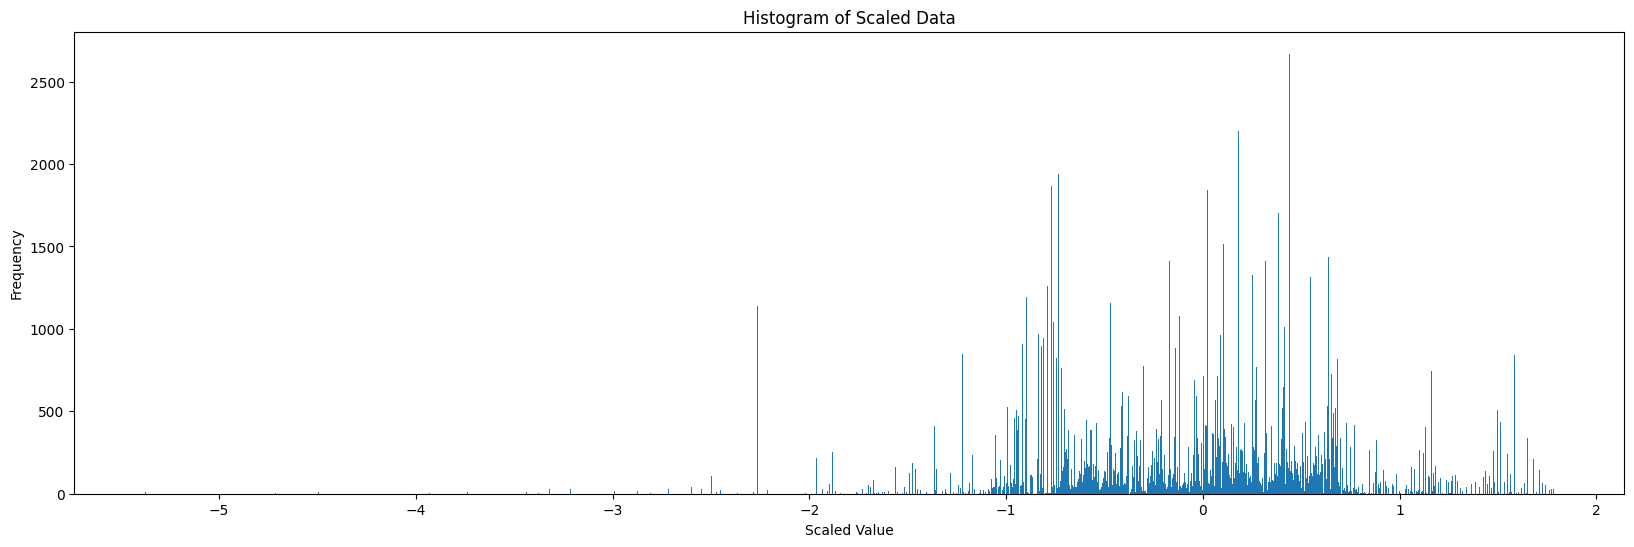

In [113]:
plt.figure(figsize=(20, 6))  # Set the figure size to 10 inches by 6 inches
plt.hist(scaled_data_3000_500, bins=1750)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

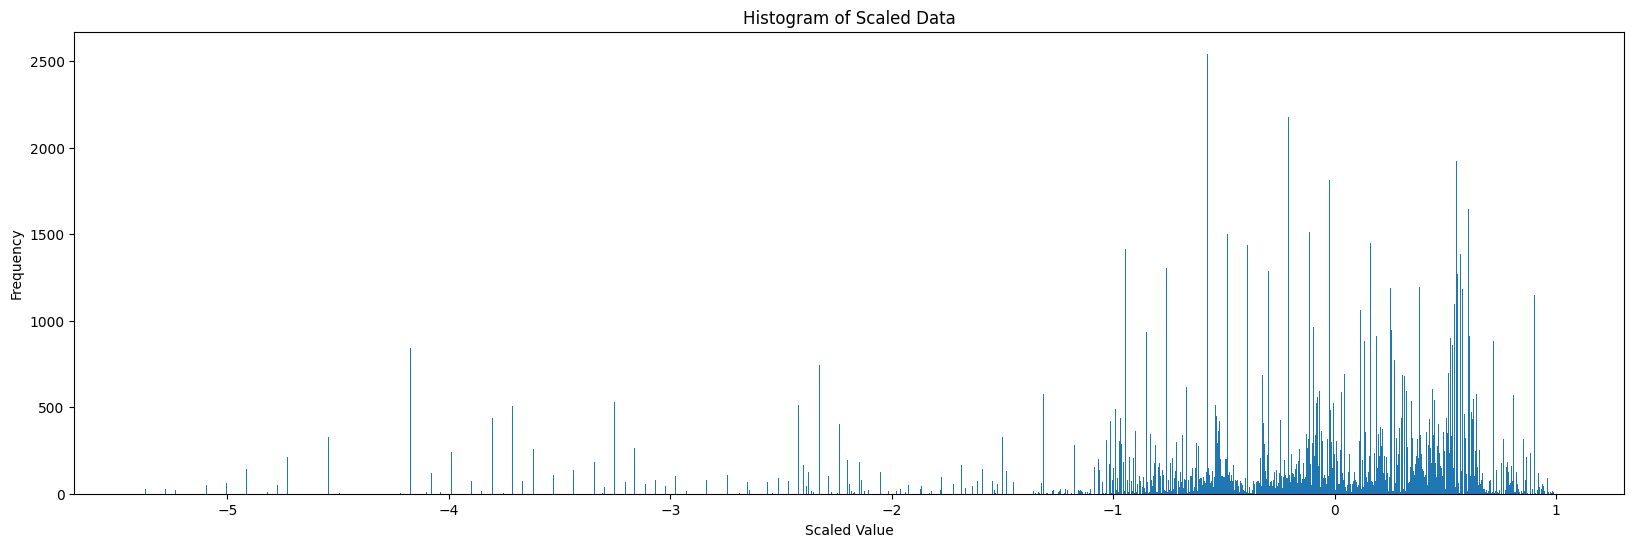

In [106]:
plt.figure(figsize=(20, 6))  # Set the figure size to 10 inches by 6 inches
plt.hist(scaled_data_3000_500_2, bins=1750)
plt.xlabel("Scaled Value")
plt.ylabel("Frequency")
plt.title("Histogram of Scaled Data")
plt.show()

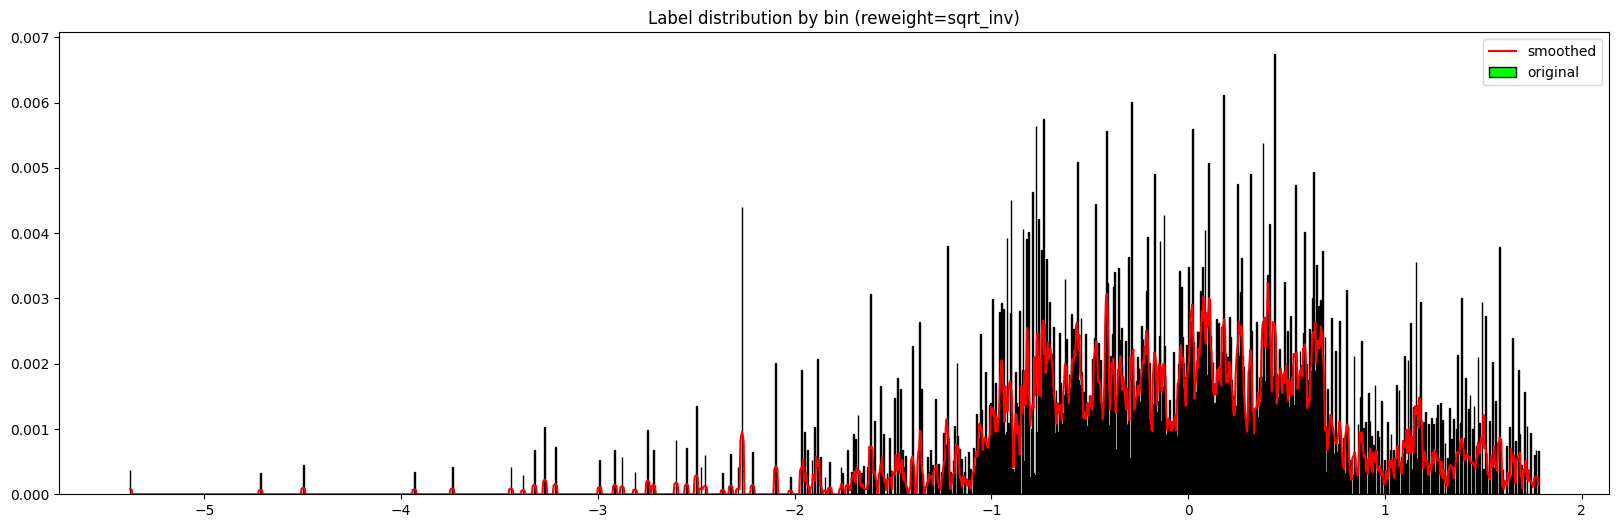

In [119]:
w = prepare_LDS_weights(
    scaled_data_3000_500,
    # normal_data,
    n_bins=1750,
    # label_range=(-3000, 2021),
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
)

In [121]:
w.shape

torch.Size([135265, 1])

In [122]:
scaled_data_3000_500.shape

(135265, 1)

In [124]:
dataset["train"]

Dataset({
    features: ['image', 'label', '__index_level_0__'],
    num_rows: 142208
})

In [126]:
config = "bm5-white_date"

args = ConfigLoader(config, "../configs/train_bm_configs.yaml", "../configs/train_bm_default.yaml")


# Load dataset, filter out na inputs and labels and encode labels (as label column can change)
if args.problem_type == "image":
    fts = ["image", args.label_col]
elif args.problem_type == "text":
    fts = [args.text_column, args.label_col]
ds_lim = (
    load_dataset(args.dataset)["train"]
    .select_columns(fts)
    .to_pandas()
    .dropna(subset=[args.label_col], inplace=False)
)

# num_counts = ds_lim[args.label_col].value_counts()
# ds_lim = ds_lim[ds_lim[args.label_col].isin(num_counts[num_counts > args.lower_lim].index)]

ds_lim = ds_lim[(ds_lim[args.label_col] > -3000) & (ds_lim[args.label_col] < 500)]

train, val_test = train_test_split(
    ds_lim,
    # stratify=ds_lim[args.label_col],
    test_size=2 * args.testset_size,
    random_state=42,
)
val, test = train_test_split(
    val_test,
    # stratify=val_test[args.label_col],
    test_size=0.5,
    random_state=42,
)
del ds_lim, val_test
gc.collect()

Updating with:
{'config': 'bm5-white_date', 'dataset': 'james-burton/BritishMuseum-white', 'wandb_proj_name': 'British Museum', 'model_base': 'google/efficientnet-b3', 'problem_type': 'image', 'lower_lim': 5, 'label_col': 'production_date_middle'}


{'config': 'bm5-white_date', 'fast_dev_run': False, 'do_train': True, 'do_predict': True, 'batch_size': 128, 'output_root': 'models/', 'num_epochs': 100, 'early_stopping_patience': 5, 'grad_accumulation_steps': 1, 'seed': 42, 'logging_steps': 10, 'lr_scheduler': 'linear', 'warmup_ratio': 0, 'weight_decay': 0, 'device': 'cuda', 'num_workers': 1, 'resume_from_checkpoint': False, 'predict_batch_size': 16, 'save_total_limit': 1, 'lr': 5e-05, 'pytorch2_0': True, 'max_length': 512, 'text_column': 'Description', 'fp16': True, 'testset_size': 0.13, 'dataset': 'james-burton/BritishMuseum-white', 'wandb_proj_name': 'British Museum', 'model_base': 'google/efficientnet-b3', 'problem_type': 'image', 'lower_lim': 5, 'label_col': 'production_date_middle'}

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

107788

In [128]:
train[args.label_col].values

array([   68.,   283., -2050., ...,  -360., -1338.,  -900.])

In [141]:
############################## Label distribution smoothing ##############################


def transform_labels(data, scaler=None):
    r"""Function to transform the labels"""
    lower_bound = -3000
    upper_bound = 500
    data = np.clip(data, lower_bound, upper_bound)
    data = -data
    lower_bound = -upper_bound
    upper_bound = -lower_bound
    data = np.log(data - lower_bound + 1)

    if scaler is None:
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(data)
        return scaled_data, scaler
    else:
        scaled_data = scaler.transform(data)
        return scaled_data


def inverse_transform_labels(data, scaler):
    r"""Function to inverse transform the labels"""
    inv_lower_bound = -500
    inv_upper_bound = 3000

    data = scaler.inverse_transform(data)

    data = np.exp(data) - 1 + inv_lower_bound
    data = -data
    return data


# scaled_data, scaler = transform_labels(normal_data)
train_labels, scaler = transform_labels(train[args.label_col].values.reshape(-1, 1))
train["label"] = train_labels
val["label"] = transform_labels(val[args.label_col].values.reshape(-1, 1), scaler)
test["label"] = transform_labels(test[args.label_col].values.reshape(-1, 1), scaler)

train["lds_weights"] = prepare_LDS_weights(
    train[args.label_col],
    n_bins=1750,
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
    show_plot=False,
).reshape(-1, 1)
val["lds_weights"] = 1
test["lds_weights"] = 1

In [143]:
w = prepare_LDS_weights(
    train[args.label_col],
    # normal_data,
    n_bins=1750,
    reweight="sqrt_inv",
    lds_ks=5,
    lds_sigma=2,
    show_plot=False,
).reshape(-1, 1)

In [145]:
w.reshape(-1, 1)

tensor([[0.5124],
        [0.7686],
        [1.9809],
        ...,
        [1.2182],
        [3.6112],
        [3.6545]])

: 

In [ ]:
# Chunking is necessary as the dataset is too large to fit into memory
chunk_size = 10000
train_chunk_data = []
for i in range(0, len(train), chunk_size):
    train_chunk = train[i : i + chunk_size]
    train_chunk_dataset = Dataset.from_pandas(train_chunk)
    train_chunk_data.append(train_chunk_dataset)

# Concatenate the chunks into a single Dataset
train = concatenate_datasets(train_chunk_data)
val = Dataset.from_pandas(val)
test = Dataset.from_pandas(test)
dataset = DatasetDict(
    {
        "train": train,
        "validation": val,
        "test": test,
    }
)
dataset = dataset.rename_column(args.label_col, "label")